In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date

import statsmodels.api as sm
import statsmodels.formula.api as smf

import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input

%matplotlib inline 

#### Model 2: Neural Networks

In [ ]:
# Function to generate input data for Nnet  
def prep_Nnet_data (data, cat_col_list, expr_, expo_col): 
    # convert categorical values to integers using categorical code
    for cat_col in cat_col_list:
        cat_col_old=cat_col
        cat_col=cat_col+'Code'
        data[cat_col]=data[cat_col_old].astype('category').cat.codes
    train = data

    # use category codes for each categorical feature as input for nnet model
    inputs=[]
    for cat_col in cat_col_list:
        inputs.append(tf.constant((train[cat_col+'Code']), dtype=tf.int32))

    # use GLM residual as targets for Nnet
    mod_p = smf.glm(formula=expr_, data=train, offset=np.log(train[expo_col]), 
                     family=sm.families.Poisson(link=sm.families.links.Log()))
    res_p=mod_p.fit()   
    targets = tf.constant(res_p.resid_deviance, dtype=tf.float32)

    print("NNET data ready")
    return [inputs, targets], train

In [ ]:
# Define EmbeddingNN model using the Keras API in TensorFlow
def create_model(num_categories_list, embedding_dim_list, hidden_sizes):
    num_hidden_layers=len(hidden_sizes)
    inputs = []
    embeddings = []
    
    # Create separate input layer for each categorical feature
    for i, num_categories in enumerate(num_categories_list):
        input_layer = Input(shape=(1,), dtype='int32')
        inputs.append(input_layer)
        
        embedding_layer = Embedding(input_dim=num_categories, output_dim=embedding_dim_list[i],
                                    input_length=1, name='category_embeddings_'+str(i))(input_layer)
        flatten_layer = Flatten()(embedding_layer)
        embeddings.append(flatten_layer)   
    # Concatenate the embeddings from all categorical features
    combined_embeddings = tf.keras.layers.concatenate(embeddings)
    concatenated_inputs = combined_embeddings
    # Add multiple hidden layers
    for i in range(num_hidden_layers):
        print("layer {:d} with {:d} nodes".format(i,hidden_sizes[i] ))
        concatenated_inputs = Dense(hidden_sizes[i], use_bias=False, activation='linear')(concatenated_inputs)  
    output = Dense(1, use_bias=False, activation='linear')(concatenated_inputs)    
   
    model = Model(inputs=inputs, outputs=output)  
    return model

In [ ]:
# Run nnet model and generate the weights for each categorical level
# target= GLM residule, inputs= categorical levels
def generate_cat_embed(model, optimizer, loss_function, 
                       train_data, epochs, batch_size, early_stopping_callback,
                       random_seed=0):
    tf.random.set_seed (random_seed)
    inputs, targets = train_data

    model.compile(optimizer=optimizer, loss=loss_function)
    history = model.fit(inputs, targets,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_split=0.2, 
                            callbacks=[early_stopping_callback], 
                            verbose=1,
                        )   
    # Get the final embedding weights after training (it only works for 2 category features)
    embedding_layer_names = [layer.name for layer in model.layers if layer.name.startswith('category_embeddings')]
    num_categories=[model.get_layer(embedding_layer_names[i]).get_weights()[0].shape[0] for i in range(len(embedding_layer_names))]
    embedding_size=[model.get_layer(embedding_layer_names[i]).get_weights()[0].shape[1] for i in range(len(embedding_layer_names))]
    embedding_wtd=np.zeros((np.sum(num_categories),np.sum(embedding_size) ))
    embedding_wtd[:num_categories[0],:embedding_size[0]]=model.get_layer(embedding_layer_names[0]).get_weights()[0]
    embedding_wtd[num_categories[0]:,embedding_size[0]:]=model.get_layer(embedding_layer_names[1]).get_weights()[0]

    comb_wtd=embedding_wtd
    for i in range(len(embedding_layer_names),len(model.get_weights()),1):
        comb_wtd = comb_wtd @ model.get_weights()[i]
        print(comb_wtd.shape)
    
    comb_wtd_dict_1 = {idx: level.item() for idx, level in enumerate(comb_wtd[:num_categories[0]])}
    comb_wtd_dict_2 = {idx: level.item() for idx, level in enumerate(comb_wtd[num_categories[0]:])}

    return comb_wtd_dict_1, comb_wtd_dict_2, pd.DataFrame(history.history)

In [ ]:
today = '2023-08-24'#str(date.today())
output_fname='results/'+today

In [ ]:
# Model 1 -  GLM model and prepare NNET data
dfFull=pd.read_csv('model_train.csv', index_col=0)
data = dfFull
expo_col='Expo'
geo_col='cls_0'
cat_col=['VehGroup',geo_col]
GLM_expr_='Cnt ~ VehYear + Gender * DrivAge'
data_seed=42
data[geo_col]=data[geo_col].astype('category')
train_data, train = prep_Nnet_data (data, cat_col, GLM_expr_, expo_col)

# 2. Nnet model
print("initiating NNET at ", datetime.datetime.now()) 
num_categories = data[cat_col].nunique().to_list()
epochs = 100
batch_size=64
learning_rate=0.001
patience=5
loss_function = losses.MeanSquaredError()#poisson_deviance#
activation_function='linear'

# testing different parameters for embedding dimension and number of hidden layers
for embedding_size in [[1,1],[1,2],[2,1],[2,2]]:
    embedding_size = np.array(embedding_size)
    for i_hidden_size in range(0,12,4):
    print("update varaible at ", datetime.datetime.now()) 
    if i_hidden_size==0:
        hidden_size=[]
    else:
        hidden_size=[int(np.sum(num_categories)/(2**i)) for i in range(1,i_hidden_size)]
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    early_stopping_callback = callbacks.EarlyStopping(patience=patience, restore_best_weights=True, verbose=1, mode="min")
    inputs, targets = train_data
    model_label=str(embedding_size[0])+'_'+str(embedding_size[1])+'_'+str(len(hidden_size))

    model = create_model(num_categories, embedding_size, hidden_size)
    model.compile(optimizer=optimizer, loss=loss_function)
    history = model.fit(inputs, targets,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_split=0.2, 
                            callbacks=[early_stopping_callback], 
                            verbose=0,
                        )   
    comb_wtd_dict_0,comb_wtd_dict_1, dfHistory = generate_cat_embed(model, optimizer, loss_function, 
                             train_data, epochs, batch_size, early_stopping_callback,
                             random_seed=0)
    dfHistory.to_csv(output_fname+'_History_'+model_label+'.csv')

    for i, cat_c in enumerate(cat_col):
        train[cat_c+'_wtd'] = train[cat_c+'Code'].map(eval('comb_wtd_dict_'+str(i)))
        dfNnetWtd=train[[cat_c, cat_c+'_wtd']].drop_duplicates()    
        dfNnetWtd.to_csv(output_fname+'_'+cat_c+'_wtd_'+model_label+'.csv')

##### results from NNET models

In [2]:
folder_name='results/2023-08-24/2023-08-24_'
dfNNET_history_1 = pd.DataFrame()
for d1 in range(1,2):
    for d2 in range(1,2):
        for n_layer in [0,3,7]:
            model_name = "{:d}_{:d}_{:d}".format(d1, d2, n_layer)
            dfTemp = pd.read_csv(folder_name + 'History_'+ model_name + '.csv').rename(columns={'Unnamed: 0':'epoch'})
            dfTemp['model'] = str(n_layer)+' hidden layers'
            dfNNET_history_1=pd.concat([dfNNET_history_1, dfTemp], axis=0, ignore_index=True)
del dfTemp

In [3]:
dfNNET_history_2 = pd.DataFrame()
for d1 in range(1,3):
    for d2 in range(1,3):
        for n_layer in range(1):
            model_name = "{:d}_{:d}_{:d}".format(d1, d2, n_layer)
            dfTemp = pd.read_csv(folder_name + 'History_'+  model_name + '.csv').rename(columns={'Unnamed: 0':'epoch'})
            dfTemp['model'] = 'veh: ' + str(d1) +', state: ' + str(d2)
            dfNNET_history_2=pd.concat([dfNNET_history_2, dfTemp], axis=0, ignore_index=True)
del dfTemp

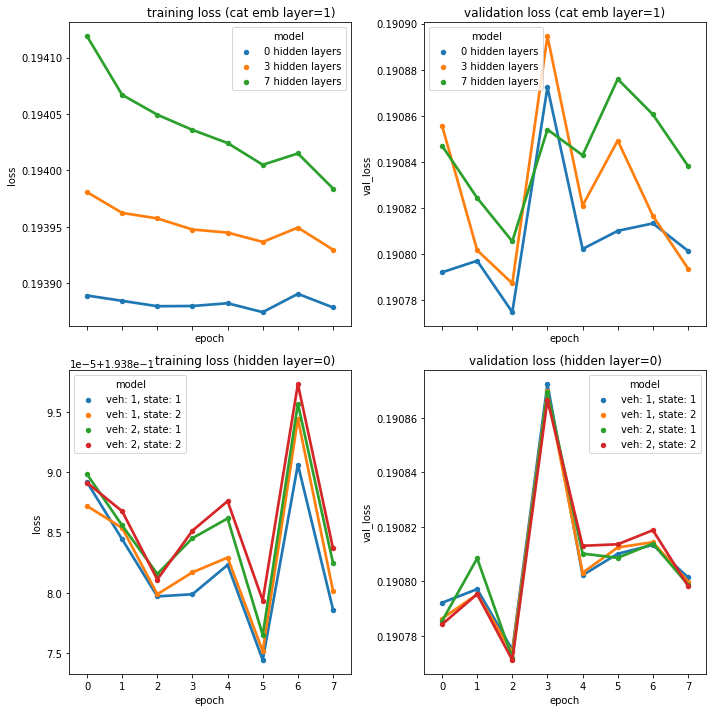

In [5]:
fig,axs=plt.subplots(2,2,figsize=(5*2,5*2),sharex=True, sharey=False)
sns.pointplot(data=dfNNET_history_1,
              x='epoch', y='loss', hue='model',markers='.', cmap='tab20', ax=axs[0,0])
axs[0,0].set_title('training loss (cat emb layer=1)    ', loc='right')
sns.pointplot(data=dfNNET_history_1,
              x='epoch', y='val_loss', hue='model',markers='.', cmap='tab20', ax=axs[0,1]).set(
    title='validation loss (cat emb layer=1)')
sns.pointplot(data=dfNNET_history_2,
              x='epoch', y='loss', hue='model',markers='.', cmap='tab20', ax=axs[1,0])
axs[1,0].set_title('training loss (hidden layer=0)    ', loc='right')
sns.pointplot(data=dfNNET_history_2,
              x='epoch', y='val_loss', hue='model',markers='.', cmap='tab20', ax=axs[1,1]).set(
    title='validation loss (hidden layer=0)')
plt.tight_layout()
plt.savefig('ppt/jupyter output/NNET_tests_2.png', bbox_inches='tight')
plt.show();

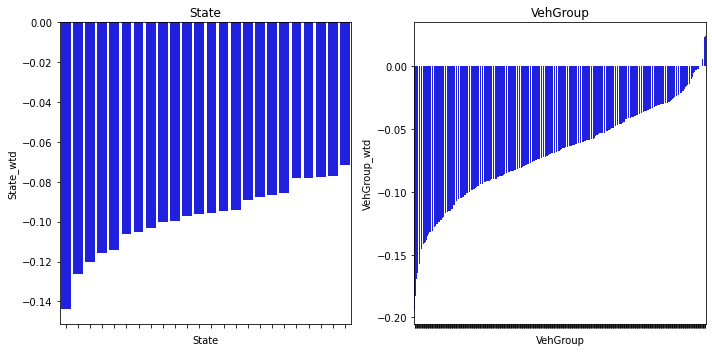

In [46]:
model_name = "_wtd_{:d}_{:d}_{:d}".format(1, 1, 0)

var_name=['State', 'VehGroup']
dfState_wtd=pd.read_csv(folder_name+'cls_0'+model_name+'.csv')[['cls_0_wtd']].reset_index().rename(
    columns={'index':var_name[0],'cls_0_wtd':'State_wtd' })
dfVeh_wtd=pd.read_csv(folder_name+var_name[1]+model_name+'.csv')[[var_name[1]+'_wtd']].reset_index().rename(
    columns={'index':var_name[1]})

fig,axs=plt.subplots(1,2,figsize=(5*2,5*1),sharex=False, sharey=False)
for i, df in enumerate([dfState_wtd, dfVeh_wtd]):
    sns.barplot(data=df.sort_values(by=var_name[i]+'_wtd'),
              x=var_name[i], y=var_name[i]+'_wtd',
                order=df.sort_values(by=var_name[i]+'_wtd')[var_name[i]], ax=axs[i],color='blue'
               ).set(title=var_name[i], xticklabels=[])
plt.tight_layout()
plt.show();